<a href="https://colab.research.google.com/github/LapTQ/facial_beauty_perception/blob/main/facial_beauty_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [1]:
#@title Download dataset

!git clone https://github.com/LapTQ/facial_beauty_perception
!git clone https://github.com/LapTQ/mlapplications.git
!pwd

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11942, done.
remote: Counting objects: 100% (11942/11942), done.
remote: Compressing objects: 100% (11925/11925), done.
remote: Total 11942 (delta 501), reused 11036 (delta 14), pack-reused 0
Receiving objects: 100% (11942/11942), 336.79 MiB | 10.93 MiB/s, done.
Resolving deltas: 100% (501/501), done.
Checking out files: 100% (11152/11152), done.
Cloning into 'mlapplications'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 73 (delta 20), reused 56 (delta 19), pack-reused 11
Unpacking objects: 100% (73/73), done.
Checking out files: 100% (14/14), done.
/content


In [2]:
#@title Import library and utilities

!pip install git+https://github.com/tensorflow/docs
!pip install tf-keras-vis tensorflow
!pip install mtcnn

import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
import seaborn as sns

import numpy as np
import pandas as pd
import random
import math
import cv2
from mtcnn.mtcnn import MTCNN
import PIL
from sklearn.model_selection import train_test_split
import pathlib

import tensorflow as tf
from tensorflow.keras import applications, layers, models
from tensorflow.keras.preprocessing import image
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.constraints import max_norm

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam

seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def plot_img(img, scores, labels):
    scores = [np.squeeze(i) for i in scores]
    plt.imshow(img) 
    
    if len(labels) == 2:
        plt.title('true: %.2f | pred: %.2f' % (scores[0], scores[1]))
    else:
        plt.title('%s: %.2f' % (labels[0], scores[0]))

    plt.axis('off')

def plot_scores(scores, labels):
    scores = [np.squeeze(i) for i in scores]
    this_plot = plt.bar(labels, scores)
    if len(labels) == 2:
        this_plot[0].set_color('green')
        this_plot[1].set_color('firebrick')
    elif labels[0] == 'true':
        this_plot[0].set_color('green')
    else:
        this_plot[0].set_color('firebrick')
    plt.yticks(range(6))

def vis_saliency(model, img, score):
    """Visualize saliency map of a model w.r.t an image.

    Arguments:
        model - keras model.
        img - image of shape compatible with model's input.
        score - true score for facial in the image.
    """

    def score_function(output):
        return 1.0 / (tf.math.abs(output[:, 0] - score) + tf.keras.backend.epsilon())

    model_saliency = Saliency(
        model,
        model_modifier=ReplaceToLinear(),
        clone=True
    )

    saliency_map = model_saliency(
        score_function, 
        img
    )
    
    plt.imshow(saliency_map[0], cmap='jet')
    plt.axis('off')


img_dir_path = 'facial_beauty_perception/FBP5500/Images/'

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-bbws41u5
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-bbws41u5
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=173555 sha256=81fcd8380bc9af480b661414868059b868bcd2014ebaf0d8554b3407b0696ebe
  Stored in directory: /tmp/pip-ephem-wheel-cache-d16pb4ke/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 2.3 MB 7.6 MB/s 


## Load images

In [3]:
#@title Choose hyper-parameter
batch_size = "32" #@param [32, 64, 128, 256]

batch_size = int(batch_size)

scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


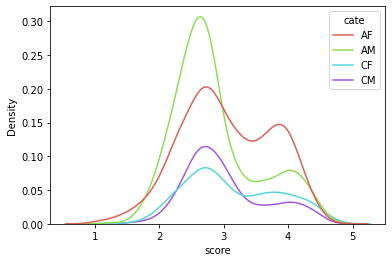

cate
AF    2000
AM    2000
CF     750
CM     750
Name: score, dtype: int64

In [70]:
#@title Show some statistics of the dataset

print(scores_dataframe['score'].describe())

scores_dataframe['cate'] = scores_dataframe.apply(lambda row: row['file_name'][:2], axis=1)
sns.kdeplot(data=scores_dataframe, x='score', hue='cate', common_norm=True, palette="hls")
plt.show()
scores_dataframe.groupby('cate')['score'].count()

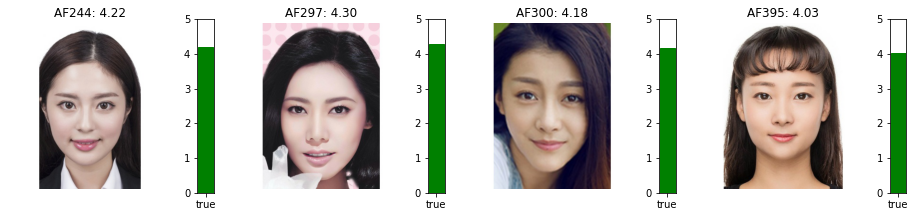

In [68]:
# @title Show some images and their beauty score
group = '4' #@param [1, 2, 3, 4]
n =  4#@param {type:"integer"}
shift =  124#@param {type:"integer"}
cate = 'AF' #@param ['AF', 'AM', 'CF', 'CM']

group = int(group)

i = j = 0
num_cols = 6
num_rows = math.ceil(n / num_cols)
plt.figure(figsize=(3.2*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows, width_ratios=[10, 1]*num_cols)
while i < n and shift + j < 5500:
    if shift + j < 5500 and group < scores_dataframe['score'][shift + j] < group + 1 and scores_dataframe['cate'][shift + j] == cate:
        img = image.load_img(img_dir_path + scores_dataframe['file_name'][shift + j])
        img = image.img_to_array(img, dtype=np.int32)

        true = scores_dataframe['score'][shift + j]

        plt.subplot(spec[2*i])
        plot_img(img, [true], [scores_dataframe['file_name'][shift + j][:-4]])

        plt.subplot(spec[2*i + 1])
        plot_scores([true], ['true'])

        i += 1
    
    j += 1

plt.tight_layout()
plt.show()

In [ ]:
#@title Choose test-size ratio
test_size = 0.2 #@param {allow-input: true}

train_scores_df, test_scores_df = train_test_split(scores_dataframe, test_size=test_size, shuffle=True, random_state=seed)

print('%d images for train_ds' % (len(train_scores_df)))
print('%d images for test_ds' % (len(test_scores_df)))

4400 images for train_ds
1100 images for test_ds


## Utilities

In [ ]:
# containers for models and training histories
models = {}
epoch_record = {}
histories = {}

In [ ]:
#@title Define training and plotting helpers

def remove_model(name):
    try:
        del models[name]
        del histories[name]
        del epoch_record[name]
    except:
        pass

def train_model(model, optimizer, max_epochs, reduce_lr_patience, early_stop_patience, checkpoint_name):

    print('[TRAINING] ', model.name)

    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=reduce_lr_patience, verbose=1),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, verbose=1, restore_best_weights=True),
                ]
    if checkpoint_name is not None:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/{}.hdf5'.format(checkpoint_name), monitor='val_loss', verbose=1, save_best_only=True))
    
    # if a model is about to trained further, keep its history
    new_model = True
    if model.name in histories.keys() and input("'{}' already exists. Override? [y/n] ".format(model.name)) != 'y':
        new_model = False

    if new_model:
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.MeanAbsoluteError()
        )
        histories[model.name] = model.fit(
            train_ds,
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,
            validation_data=test_ds,
            callbacks=callbacks,
            shuffle=True
        )
        epoch_record[model.name] = [histories[model.name].epoch[-1]]

    else:
        model.optimizer.learning_rate.assign(optimizer.get_config()['learning_rate'])
        cont_history = model.fit(
            train_ds, 
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,     
            validation_data=test_ds,    
            callbacks=callbacks,
            initial_epoch=histories[model.name].epoch[-1] + 1,
            shuffle=True
        )
        epoch_record[model.name].append(cont_history.epoch[-1])
        histories[model.name].epoch += cont_history.epoch
        histories[model.name].history['loss'] += cont_history.history['loss']
        histories[model.name].history['val_loss'] += cont_history.history['val_loss']

    return model.name


plotter = tfdocs.plots.HistoryPlotter( 
    metric = 'loss',
    # smoothing_std=10
)

## Image without face extracted

In [ ]:
#@title Configure base dataset

@tf.function
def filename_to_img(filename, label):
    """
    Read image from disk.
    
    Arguments:
        filename - string, to image filename.
        label - number, score of the face in the image.
    
    Return:
        img - tensor, image as ndarray.
        label - number, score of the face in the image.
    """
    img_string = tf.io.read_file(img_dir_path + filename)
    
    # Don't use tf.image.decode_image, or the output shape will be undefined
    img = tf.image.decode_jpeg(img_string)  #########################

    # This will convert to float values in [0, 1]
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # img = tf.image.resize(img, (224, 224))

    return img, label

train_ds_raw = tf.data.Dataset.from_tensor_slices((train_scores_df['file_name'], train_scores_df['score']))
test_ds_raw = tf.data.Dataset.from_tensor_slices((test_scores_df['file_name'], test_scores_df['score']))

def configure_dataset(ds, training):
    """ Map augmentation and configuration for performance.
    This function 
        1. read image as ndarray from disk.
        2. resize to (244, 224) while keeping aspect ratio.
        3. do augmenation: flip, rotate, zoom, translate, add noise; change contrast, quality, brightness, saturation.
        4. shuffle (training only)
        5. batch dataset

    Arguments:
        ds - SlideDataset, dataset contraining image filename.
        training - bool, if ds is training dataset or not.

    Return
        ds - configured dataset
    """

    data_augmentation = tf.keras.Sequential(
        [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.06),
        layers.RandomZoom((-0.3, 0.08)),
        layers.RandomTranslation(0.14, 0.14),
        layers.GaussianNoise(0.3),
        layers.RandomContrast(0.5)
        ]
    )
    
    ds = ds.map(filename_to_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (layers.Resizing(224, 224, crop_to_aspect_ratio=True)(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=5500)
    ds = ds.cache()
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_jpeg_quality(x / 255., 14, 100) * 255., y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_brightness(x / 255., 0.2) * 255., y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_saturation(x / 255., 0.5, 1.4) * 255., y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.shuffle(buffer_size=5500)
    ds = ds.batch(batch_size)
    
    return ds

In [ ]:
train_ds = configure_dataset(train_ds_raw, training=True)
test_ds = configure_dataset(test_ds_raw, training=False)

In [ ]:
#@title Plot augmented train dataset

do_plot = 'yes' #@param ['no', 'yes']

if do_plot == 'yes':

    plt.figure(figsize=(20, 10))
    for img, sco in train_ds.take(1):
        print(img.shape)
        for i in range(32):
            ax = plt.subplot(4, 8, i + 1)
            plt.imshow(np.clip(tf.cast(img[i], tf.int32), 0, 255))
            plt.axis("off")
    plt.show()

In [ ]:
mobile_net = applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False, include_preprocessing=True)
output = layers.Flatten()(mobile_net.output)
output = layers.Dense(256, activation='relu')(output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(128, activation='relu')(output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(1)(output)

models['mobile_net'] = Model(mobile_net.input, output, name='mobile_net')

train_model(models['mobile_net'], SGD(learning_rate=5e-3, momentum=0.9, nesterov=True), max_epochs=30, reduce_lr_patience=3, early_stop_patience=8, checkpoint_name=None)

{}
{'mobile_net': [15, 24]}


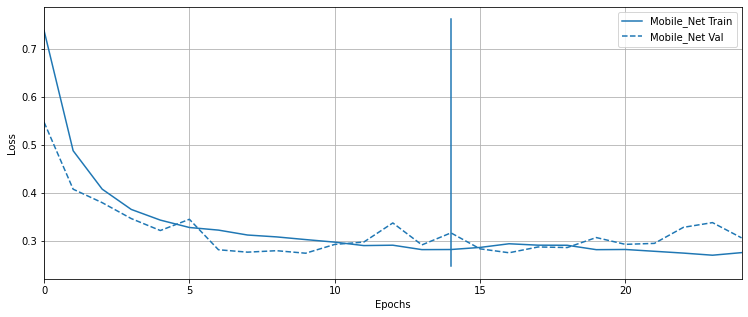

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([140, 170])
# plt.ylim([0, 0.5])
plt.xlabel('Epochs')

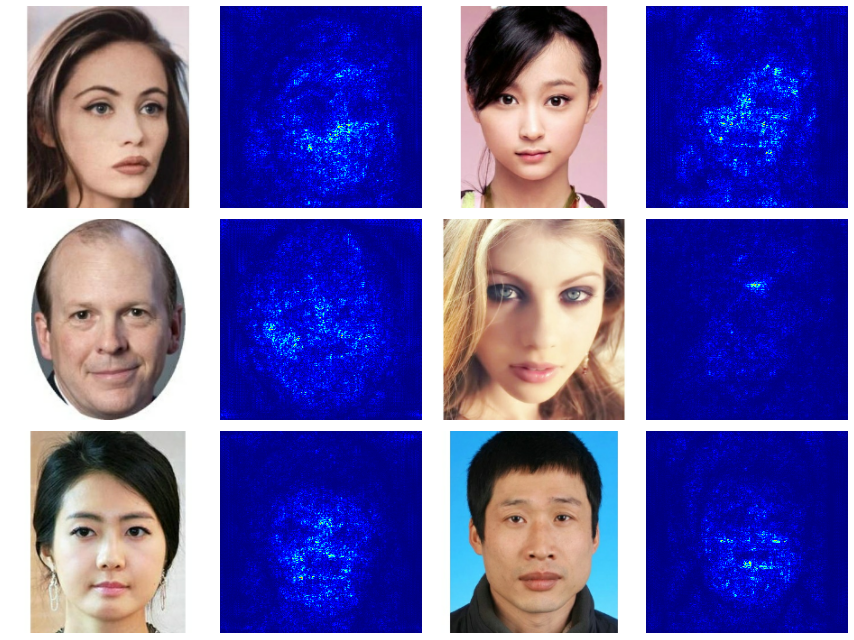

In [ ]:
#@title Plot heatmap and saliency map of some images in test set

img_num = 6 #@param {type:"integer"}

num_cols = 2 #@param {type:"integer"}
num_rows = math.ceil(img_num / num_cols)
plt.figure(figsize=(2*3*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows)

i = 0
for img_batch, score_batch in test_ds.take(1):
    for img, score in zip(img_batch, score_batch):

        plt.subplot(spec[2*i])
        plt.imshow(tf.cast(img, tf.int32))
        plt.axis('off')

        plt.subplot(spec[2*i + 1])
        vis_saliency(models['mobile_net'], img, score.numpy())

        i += 1

        if i == img_num:
            break

plt.tight_layout()
plt.show()

## Image with face extracted

In [ ]:
#@title Configure base dataset

def extract_face(img):
    """Extract face patch from an image.

    Argument:
        img - tf tensor, image.
    
    Return:
        face - tf tensor, square image with face cropped.
    """

    # img = PIL.Image.open(img_dir_path + filename)
    # img = img.convert('RGB')
    # img = np.asarray(img)

    img = img.numpy()

    face_detector = MTCNN()
    bboxes = face_detector.detect_faces(img)
    x1, y1, width, height = bboxes[0]['box']
    x1, y1 = abs(x1), abs(y1)
    face = img[y1:y1 + height, x1:x1 + width]
    target_size = max(width, height)
    face = tf.image.resize_with_pad(face, target_size, target_size)
    return face

def pre_configure(ds):
    """Basic configuration for dataset for the sake of face extraction.
    
    This function:
        1. read file from disk.
        2. extract face from image.
        3. cache dataset.
    """

    ds = ds.map(filename_to_img,
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (tf.py_function(extract_face, [x], Tout=tf.float32), y), 
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.prefetch(buffer_size=5500)
    ds = ds.cache()

    return ds

def post_configure(ds, training, target_size):
    """Futher configuration for dataset.
    
    This function:
        1. resize to desired shape.
        2. do augmentation (training only): flip, rotate, add noise; change contrast, quality, brightness, saturation.
        3. batch dataset.

    """
    
    data_augmentation = tf.keras.Sequential(
        [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.06),
        layers.GaussianNoise(0.3),
        layers.RandomContrast(0.5)
        ]
    )

    ds = ds.map(lambda x, y: (layers.Resizing(target_size, target_size, crop_to_aspect_ratio=True)(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_jpeg_quality(x / 255., 14, 100) * 255., y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_brightness(x / 255., 0.2) * 255., y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.image.random_saturation(x / 255., 0.5, 1.4) * 255., y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.batch(32)

    return ds

train_ds_base = pre_configure(train_ds_raw)
test_ds_base = pre_configure(test_ds_raw)

In [ ]:
train_ds = post_configure(train_ds_base, training=True, target_size=224)
test_ds = post_configure(test_ds_base, training=False, target_size=224)

In [ ]:
#@title Plot augmented train dataset

do_plot = 'yes' #@param ['no', 'yes']

if do_plot == 'yes':

    plt.figure(figsize=(20, 10))
    for img, sco in train_ds.take(1):
        print(img.shape)
        for i in range(32):
            ax = plt.subplot(4, 8, i + 1)
            plt.imshow(np.clip(tf.cast(img[i], tf.int32), 0, 255))
            plt.axis("off")
    plt.show()

In [ ]:
mobile_net_face = applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False, include_preprocessing=True)
output = layers.Flatten()(mobile_net_face.output)
output = layers.Dense(256, activation='relu')(output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(128, activation='relu')(output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(1)(output)

models['mobile_net_face'] = Model(mobile_net_face.input, output, name='mobile_net_face')

train_model(models['mobile_net_face'], SGD(learning_rate=5e-3, momentum=0.9, nesterov=True), max_epochs=40, reduce_lr_patience=3, early_stop_patience=8, checkpoint_name=None)

{}
{'mobile_net_face': [9, 26]}


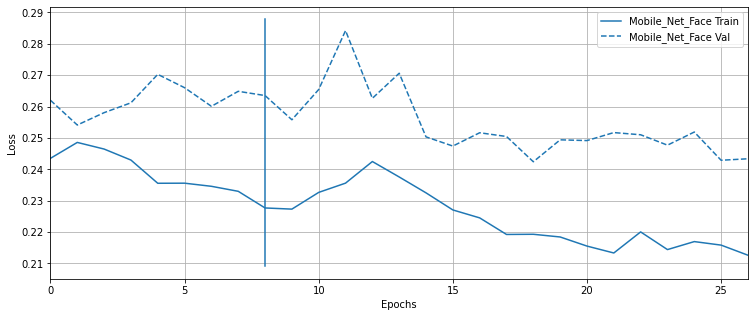

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
plt.xlabel('Epochs')

## Face embedding

In [ ]:
train_ds = post_configure(train_ds_base, training=True, target_size=160)
test_ds = post_configure(test_ds_base, training=False, target_size=160)

In [ ]:
facenet = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/facenet_keras.h5')

facenet_input = facenet.input
norm_layer = layers.LayerNormalization(axis=(1, 2, 3))  # normalize each image
norm_layer.trainable = False
output = norm_layer(facenet_input)
output = facenet(output)

output = layers.Dense(256, activation='relu')(output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(1)(output)

models['face_embedding'] = Model(facenet_input, output, name='face_embedding')

for layer in facenet.layers:
    layer.trainable = False

train_model(models['face_embedding'], SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), max_epochs=30, reduce_lr_patience=2, early_stop_patience=5, checkpoint_name=None)

{}
{'sequential_2': [13, 23, 29]}


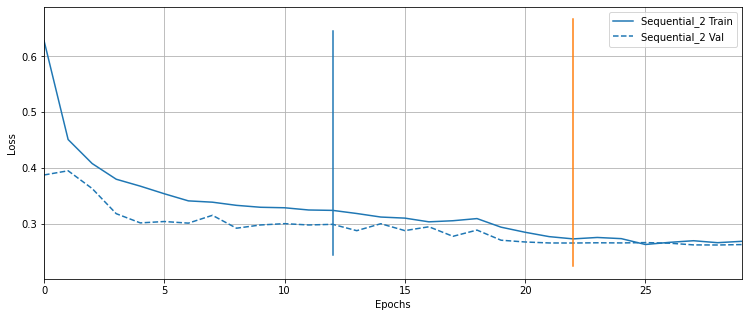

In [ ]:
plt.figure(figsize=(12.5, 5))
plotter.plot(histories)
epoch_set = set()
for name in epoch_record.keys():
    epoch_set.update(set(epoch_record[name]))
epoch_set = sorted(list(epoch_set))
for i in range(len(epoch_set) - 1):
    plt.plot([epoch_set[i] - 1, epoch_set[i] - 1], plt.ylim())
plt.xlabel('Epochs')

## Test result

In [ ]:
#@title Chọn mô hình (Select model)

mode = 'face embedding' #@param ['without face extracted', 'face extracted', 'face embedding']

model_dict = {'without face extracted': 'mobile_net', 'face extracted': 'mobile_net_face', 'face embedding': 'face_embedding'}

model = models[model_dict[mode]]

if mode == 'without face extracted':
    train_ds = configure_dataset(train_ds_raw, training=True)
    test_ds = configure_dataset(test_ds_raw, training=False)
elif mode == 'face extracted':
    train_ds = post_configure(train_ds_base, training=True, target_size=224)
    test_ds = post_configure(test_ds_base, training=False, target_size=224)
else:
    train_ds = post_configure(train_ds_base, training=True, target_size=160)
    test_ds = post_configure(test_ds_base, training=False, target_size=160)

def predict_image(img, mode):

    img_np = np.asarray(img)
    
    if mode == 'face extracted' or mode == 'face embedding':
        face_extractor = MTCNN()
        bboxes = face_extractor.detect_faces(img_np)
        faces = {'img': [], 'coord': []}
        def get_color(_):
            color = [80, 80, 40]
            color[_ % 3] *= (_ + 1)
            return color
        for _ in range(len(bboxes)):
            x1, y1, width, height = bboxes[_]['box']
            x1, y1 = abs(x1), abs(y1)
            y2, x2 = y1 + height, x1 + width
            face = img_np[y1:y2, x1:x2]
            target_size = max(width, height)
            face = tf.image.resize_with_pad(face, target_size, target_size)
            if mode == 'face extracted':
                face = tf.image.resize(face, (224, 224))
            else:
                face = tf.image.resize(face, (160, 160))
            faces['img'].append(face)
            faces['coord'].append((x1, y1, x2, y2))
            img = cv2.rectangle(img, (x1, y1), (x2, y2), get_color(_), 1)
        if len(bboxes) > 0:
            faces_ds = tf.data.Dataset.from_tensor_slices(faces['img']).batch(32)
            preds = models[model_dict[mode]].predict(faces_ds)
            for _ in range(len(bboxes)):
                cv2.putText(img, "{:.2f}".format(np.squeeze(preds[_])),
                            (faces['coord'][_][0], faces['coord'][_][1] - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                            get_color(_), 2)
                
    else:
        img_np = tf.image.resize_with_pad(img_np, 224, 224)
        preds = models[model_dict[mode]].predict(np.expand_dims(img_np, axis=0))
        cv2.putText(img, "{:.2f}".format(np.squeeze(preds)),
                    (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                    (0, 255, 0), 3)


    return {'img': img, 'preds': preds}

In [ ]:
predictions = model.predict(test_ds)
model.evaluate(test_ds)

35/35 [==============================] - 59s 2s/step - loss: 0.2626


0.26258915662765503

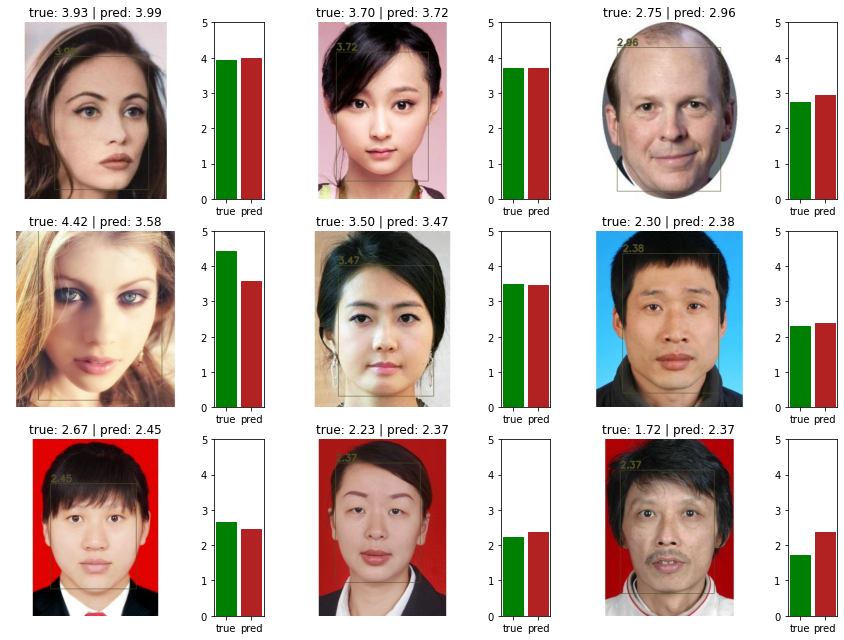

In [ ]:
#@title Show some test prediction results

n = 9 #@param {type:'integer'}

num_cols = 3
num_rows = math.ceil(n / num_cols)
plt.figure(figsize=(2*2*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows, width_ratios=[4, 1]*num_cols)
for i in range(n):

    img = cv2.imread(img_dir_path + test_scores_df['file_name'].to_numpy()[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = predict_image(img, mode)
    img, preds = result['img'], result['preds']

    true = test_scores_df['score'].to_numpy()[i]
    pred = preds[0][0]

    plt.subplot(spec[2*i])
    plot_img(img, [true, pred], ['true', 'pred'])

    plt.subplot(spec[2*i + 1])
    plot_scores([true, pred], ['true', 'pred'])

plt.tight_layout()
plt.show()

Pearson correlation between true score and predicted score on test set:
[[1.         0.86786765]
 [0.86786765 1.        ]]


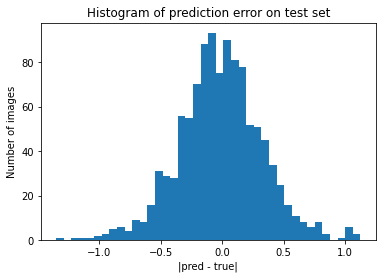

In [ ]:
#@title Plot prediction correlation and error

pred = np.squeeze(predictions)
true = test_scores_df['score'].to_numpy()

print("Pearson correlation between true score and predicted score on test set:")
print(np.corrcoef(pred, true))

plt.hist(pred - true, bins=40)
plt.xlabel('|pred - true|')
plt.ylabel('Number of images')
plt.title('Histogram of prediction error on test set')
plt.show()

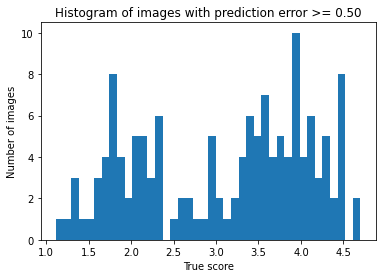

139/1100 images with prediction error >= 0.50


In [ ]:
#@title Statistics of images that are not well predicted
threshold = 0.5 #@param {type:"number"}

sub = np.abs(np.squeeze(predictions) - test_scores_df['score'].to_numpy())
plt.hist(test_scores_df['score'].to_numpy()[sub >= threshold], bins=40)
plt.xlabel('True score')
plt.ylabel('Number of images')
plt.title('Histogram of images with prediction error >= {:.2f}'.format(threshold))
plt.show()

print('{}/{} images with prediction error >= {:.2f}'.format(len(sub[sub >= threshold]), len(sub), threshold))

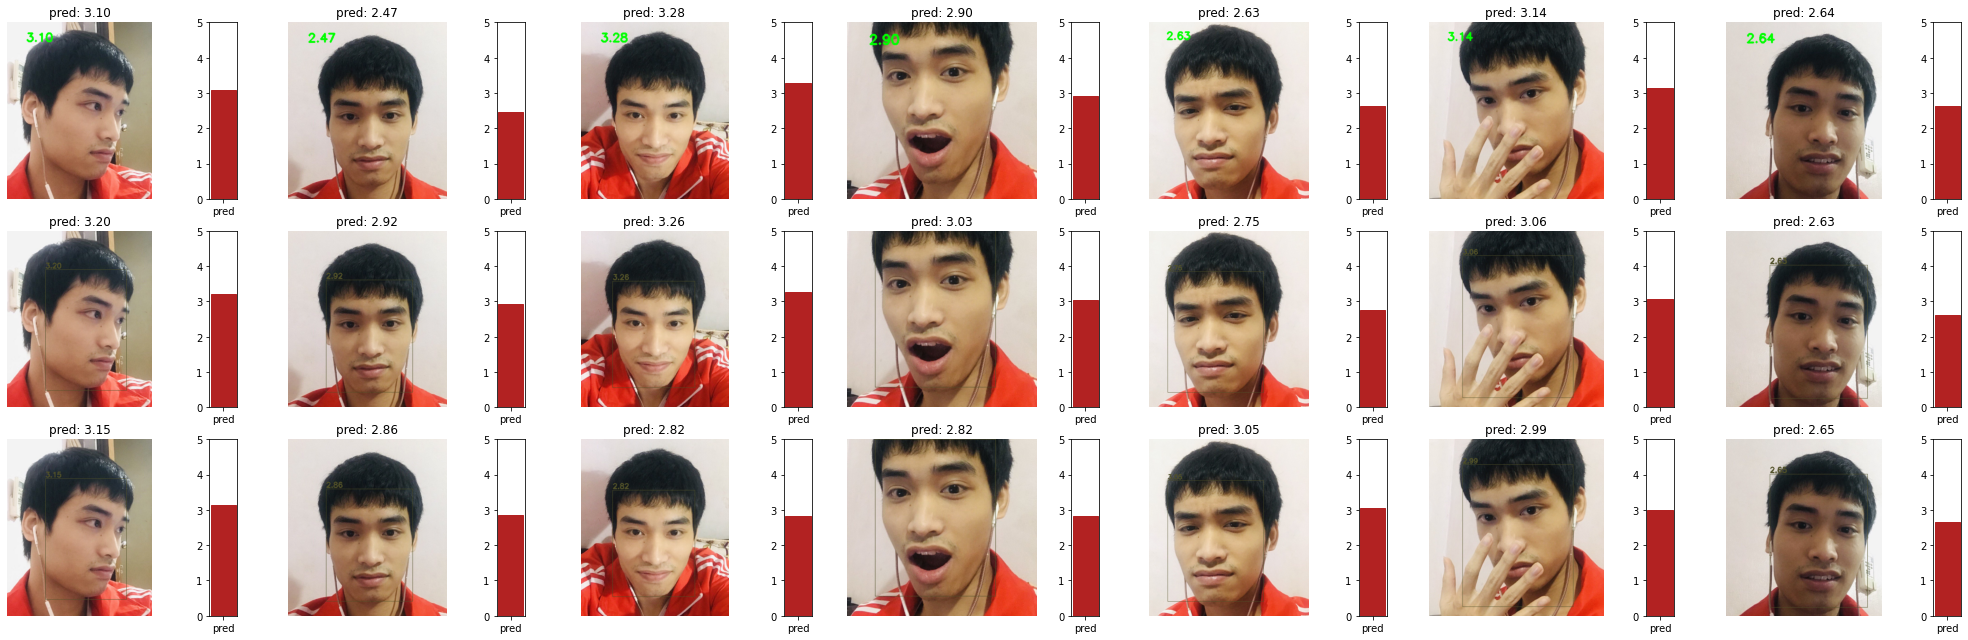

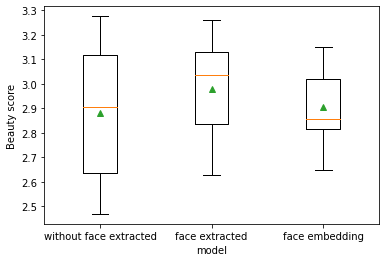

In [ ]:
#@title Prediction of 3 models on the same person

start_letter = 'l' #@param {type:"string"}
img_dir = pathlib.Path('facial_beauty_perception/test_images')

img_paths = list(img_dir.glob(start_letter + '*'))
records = {mode: [] for mode in model_dict}

num_cols = len(img_paths)
num_rows = math.ceil(len(img_paths) / num_cols) * len(model_dict)
plt.figure(figsize=(2*2*num_cols, 3*num_rows))
spec = gridspec.GridSpec(ncols=2*num_cols, nrows=num_rows, width_ratios=[8, 1]*num_cols)
j = 0
for mode in model_dict:
    model = models[model_dict[mode]]
    for i in range(len(img_paths)):
        img = cv2.imread(str(img_paths[i]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = predict_image(img, mode)
        img, preds = result['img'], result['preds']

        records[mode].append(np.squeeze(preds[0][0]))

        plt.subplot(spec[2*(j*num_cols + i)])
        plot_img(tf.cast(img, tf.int32), [preds[0][0]], ['pred'])

        plt.subplot(spec[2*(j*num_cols + i) + 1])
        plot_scores([preds[0][0]], ['pred'])
    j += 1

plt.tight_layout()
plt.show()

plt.boxplot(records.values(), labels=records.keys(), showmeans=True)
plt.ylabel('Beauty score')
plt.xlabel('model')
plt.show()

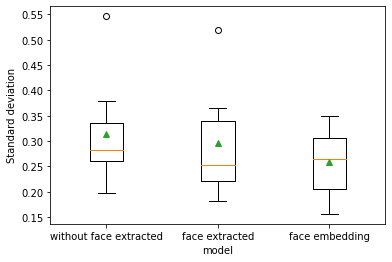

In [ ]:
#@title Compare models stability

img_dir = pathlib.Path('facial_beauty_perception/test_images')

start_letters = list(set(str(name).split('/')[-1][0] for name in list(img_dir.glob('*'))))

stds = {mode: [] for mode in model_dict}

for letter in start_letters:
    img_paths = list(img_dir.glob(letter + '*'))
    records = {mode: [] for mode in model_dict}

    for mode in model_dict:
        model = models[model_dict[mode]]
        for i in range(len(img_paths)):
            img = cv2.imread(str(img_paths[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            result = predict_image(img, mode)
            img, preds = result['img'], result['preds']

            records[mode].append(np.squeeze(preds[0][0]))
        stds[mode].append(np.std(records[mode]))


plt.boxplot(stds.values(), showmeans=True, labels=stds.keys())
plt.ylabel('Standard deviation')
plt.xlabel('model')
plt.show()

## Save and load model

In [ ]:
# models['mobile_net'].save('/content/drive/MyDrive/checkpoint/mobile_net')

In [ ]:
models['mobile_net'] = tf.keras.models.load_model('mlapplications/trained_models/fbp/mobile_net')

In [ ]:
# models['mobile_net_face'].save('/content/drive/MyDrive/checkpoint/mobile_net_face')

In [ ]:
models['mobile_net_face'] = tf.keras.models.load_model('mlapplications/trained_models/fbp/mobile_net_face')

In [ ]:
# models['face_embedding'].save('/content/drive/MyDrive/checkpoint/face_embedding')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/face_embedding/assets


In [ ]:
models['face_embedding'] = tf.keras.models.load_model('mlapplications/trained_models/fbp/face_embedding')

## Thử xem sao (Let's try it)

[Nhấp vào đây để test thử (Click here to try)](https://colab.research.google.com/github/LapTQ/mlapplications/blob/main/ML_applications.ipynb)

# Depricated code

In [ ]:
#@title Plot conv layers with activation maximization

# layer_name = 'expanded_conv_3/expand' #@param {type:"string"}

# max_layer = 16 #@param {type:"integer"}

# n = min(model.get_layer(name=layer_name).filters, max_layer)        
# filter_numbers = list(range(n))     # choose first n layers

# scores = CategoricalScore(filter_numbers)
# seed_input = tf.random.uniform((n, 224, 224, 3), 0, 255)

# activation_maximization = ActivationMaximization(model,
#                                                  model_modifier=[ExtractIntermediateLayer(index_or_name=layer_name), 
#                                                                  ReplaceToLinear()
#                                                                  ],
#                                                  clone=False)

# activations = activation_maximization(scores,
#                                       seed_input=seed_input,
#                                       callbacks=[Progress()])

# num_cols = 8
# num_rows = math.ceil(n / num_cols)
# plt.figure(figsize=(2*num_cols, 2*num_rows))
# spec = gridspec.GridSpec(ncols=num_cols, nrows=num_rows)

# for i, filter_number in enumerate(filter_numbers):

#         plt.subplot(spec[i])
#         plt.imshow(np.squeeze(activations[i]))
#         # plt.title('{}: {}'.format(layer_name, filter_number))
#         plt.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
#@title Plot dense layers with activation maximization


# activation_maximization = ActivationMaximization(model,
#                                                  model_modifier=ReplaceToLinear(),
#                                                  clone=True)


# num_cols = 5
# num_rows = 1
# plt.figure(figsize=(3*num_cols, 3*num_rows))
# spec = gridspec.GridSpec(ncols=num_cols, nrows=num_rows)

# for i in range(1, 6, 1):
    
#     def score_function(output):
#         return 1.0 / (tf.math.abs(output[:] - i) + tf.keras.backend.epsilon())

#     plt.subplot(spec[i - 1])
#     activations = activation_maximization(score_function, callbacks=[Progress()])
#     plt.imshow(activations[0])
#     plt.title(i)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
# img = image.load_img('j2.png')
# img = image.img_to_array(img)
# face_detector = MTCNN()
# bboxes = face_detector.detect_faces(img)
# x1, y1, width, height = bboxes[0]['box']
# x1, y1 = abs(x1), abs(y1)
# img = img[y1:y1 + height, x1:x1 + width]
# target_size = max(width, height)
# img = tf.image.resize_with_pad(img, target_size, target_size)

# img = tf.image.resize(img, (160, 160))
# # img = normalize(img)
# score = new(tf.expand_dims(img, axis=0))
# print(score)
# plt.imshow(img)

In [ ]:
# # facenet = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/facenet_keras.h5')
# output = facenet.input
# # output = layers.Rescaling(1/255.)(output)
# output = layers.LayerNormalization(axis=(1, 2, 3))(output)
# output = facenet(output)
# # output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)
# new = Model(facenet.input, output)

In [ ]:


# def normalize(img):
#     mean = tf.reduce_mean(img)
#     std = tf.math.reduce_std(img)
#     return (img - mean) / std

# dir = pathlib.Path('/content/facial_beauty_perception/test_images')
# fname = [str(_) for _ in dir.glob('*')]
# labs = [_.split('/')[-1][0] for _ in fname]
# imgs = []
# for name in fname:
#     img = image.load_img(name)
#     img = image.img_to_array(img)
#     face_detector = MTCNN()
#     bboxes = face_detector.detect_faces(img)
#     x1, y1, width, height = bboxes[0]['box']
#     x1, y1 = abs(x1), abs(y1)
#     img = img[y1:y1 + height, x1:x1 + width]
#     target_size = max(width, height)
#     img = tf.image.resize_with_pad(img, target_size, target_size)

#     img = tf.image.resize(img, (160, 160))
#     imgs.append(img)

# # for i in range(len(imgs)):
# #     imgs[i] = normalize(imgs[i])
# # plt.imshow(imgs[0]/255)


In [ ]:
# # imgs_n = [normalize(img) for img in imgs]

# embs = new(np.array(imgs))

# from sklearn.decomposition import PCA
# pca = PCA(2)
# embs2 = pca.fit_transform(embs)

# import seaborn as sns
# sns.scatterplot(embs2[:, 0], embs2[:, 1], hue=labs)